In [1]:
import numpy as np 
import pandas as pd 
import random
import datetime as dt
from pandas.core import datetools

pd.set_option('precision', 2)



C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  import sys


In [187]:
import time
from matplotlib import pyplot as pyplot

from sklearn import linear_model
from sklearn import tree
import csv
import os

## Preprocessign libraries
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import FunctionTransformer

# Cross-Validation and Hyper-Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

## Evaluation Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc,roc_auc_score

## Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## GGPLOT2-like library
from plotnine import *


# *READ AND COMBINE INDIVIDUAL FILES FROM ETFs*

In [2]:

### Create the functions needed to read all ETF files and read ETF files

import csv
import os
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

ETFPath = './Dataset/1Day/ETFs/'
filesETF = os.listdir(ETFPath)
def create_master_file(path, filenames, output_file):
    data_out = open(path+output_file, 'wb')
    writer_out=csv.writer(data_out,delimiter=',')
    writer_out.writerow(['Ticker','Date','Open','High','Low','Close','Volume','OpenInt'])
    for filename in filenames:
        data_in = open(path + filename,'rb')
        reader_in = csv.reader(data_in, delimiter=',')
        
        rowcount = 0
        for row in reader_in:
            if rowcount == 0:
                rowcount = 1
            else:    
                line1 = [filename,row[0],row[1],row[2],row[3],row[4],row[5],row[6]]
                writer_out.writerow(line1)
        data_in.close() 
    data_out.close()

create_master_file(ETFPath,filesETF, "AllETFs.csv")


In [27]:
###READ THE COMBINED FILE OF ETFs TO AVOID FILE READING DURING PROJECT DEVELOPMENT
#Open Combined Files
filename = './Dataset/1Day/ETFs/AllETFs.csv'
data_ETF = pd.read_csv(filename, parse_dates=[1])

## Define ETFs to be picked
Chosen_ETF = ['PNQI','ARKK','ROBO','FDN','IPAY','FINX','QQQC','ARKW','IGV','IGM','CQQQ','XTH','FXL','PRNT','RYT','SOCL','XITK','XT','XSW','FTEC','VGT','IXN','SMH','PSJ','QTEC','SKYY','JHMT','GAMR','IYW','PTF','SOXX','XWEB','TCHF','XLK','PSI','FTXL','ITEQ','HACK','TDIV','PXQ','CIBR','XSD','SNSR','PSCT','IGN','FCOM','DTEC','BLOK','BLCN']

## INITIALIZE VARIABLES
numeric_columns = ['open','high','low','close','openint'] 
date_columns = [1,8,13,18]
closing_columns = ['date','ticker','close','vix_close','vxn_close','ndxt_close','delta_close_etf','delta_close_vix','delta_close_vxn','delta_close_ndxt']
X_Cols = ['ticker',  ### Only need delta and daily change because I will only be looking into Momentum (daily delta Diff) and Volatility (daily % delta change)
          'delta_close_etf','dailychange_close_etf',
          'delta_close_vix','dailychange_close_vix',
          'delta_close_vxn','dailychange_close_vxn',
          'delta_close_ndxt','dailychange_close_ndxt']

## RENAME TICKER FIELD TO A MORE READABLE FORM
data_ETF['Ticker'] = data_ETF['Ticker'].str.replace('.us.txt','')
data_ETF['Ticker'] = data_ETF['Ticker'].str.upper()
data_ETF.columns = data_ETF.columns.str.strip().str.lower().str.replace(' ', '_')

#Backup ETF dataset
data_ETF_Backup = data_ETF

print 'ETF Columns'
print data_ETF.columns.values
print 'ETF Shape'
print data_ETF.shape



ETF Columns
['ticker' 'date' 'open' 'high' 'low' 'close' 'volume' 'openint']
ETF Shape
(2565578, 8)


# *READ MARKET AND VOLATILITY INDEX FILES* #
### MERGE ETF AND INDEX FILES INTO ONE DATASET ###

In [4]:
####READ MARKET INDEX FILES
filenameVIX = './Dataset/Jan20_vixcurrent_Jan20.csv'
dfVIX = pd.read_csv(filenameVIX,skiprows=1, parse_dates=[0])

filenameVXN = './Dataset/Jan20_vxncurrent_Jan20.csv'
dfVXN = pd.read_csv(filenameVXN,skiprows=2, parse_dates=[0])

filenameNDXT = './Dataset/Jan20_NDXT.csv'
dfNDXT = pd.read_csv(filenameNDXT, parse_dates=[0])
print "VIX"
print dfVIX.shape
print "VXN"
print dfVXN.shape
print "NDXT"
print dfNDXT.shape


VIX
(3537, 5)
VXN
(4271, 5)
NDXT
(2999, 7)


In [5]:
### Merge all index files with ETF dataframe
print "ETF Data set size", data_ETF.shape
data_ETF = data_ETF.merge(dfVIX, left_on='date', right_on='Date', how='left')
print
data_ETF = data_ETF.merge(dfVXN, left_on='date', right_on='Date', how='left')
data_ETF = data_ETF.merge(dfNDXT, left_on='date', right_on='Date', how='left')
data_ETF.rename(columns={'Date':'Date_z'}, inplace=True)
data_ETF.columns = data_ETF.columns.str.strip().str.lower().str.replace(' ', '_')

print data_ETF.dtypes


ETF Data set size (2565578, 8)

ticker                    object
date              datetime64[ns]
open                     float64
high                     float64
low                      float64
close                    float64
volume                     int64
openint                    int64
date_x            datetime64[ns]
vix_open                 float64
vix_high                 float64
vix_low                  float64
vix_close                float64
date_y            datetime64[ns]
vxn_open                 float64
vxn_high                 float64
vxn_low                  float64
vxn_close                float64
date_z            datetime64[ns]
ndxt_open                float64
ndxt_high                float64
ndxt_low                 float64
ndxt_close               float64
ndxt_adj_close           float64
ndxt_volume              float64
dtype: object


# *DATA MANIPULATION TO END UP WITH ONE DATA SET WITH COMMON DATES AND THE ETFs OF INTEREST*

In [9]:
#########################################################################
## Explore Original Dataset by focusing on Market Indexes available dates
#########################################################################

print "Total Unique Tickers" #FiltereddfETF['ticker'].value_counts()
print data_ETF['ticker'].nunique()

print "Total Unique Tickers for Chosen ETFs" #FiltereddfETF['ticker'].value_counts()
TotalTickers = data_ETF['ticker'].loc[data_ETF['ticker'].isin(Chosen_ETF)].nunique()

#print TotalTickers
FiltereddfETF = data_ETF.loc[data_ETF['ticker'].isin(Chosen_ETF)]


#Filter Dataset only for the ETFs of interest
TotalRowsPerTickers = FiltereddfETF.groupby('ticker')['ticker'].count() ## if I add ['ticker'] after teh (ticker), it will only count for the ticker instances

# Obtain minimun date per ticker
TotalChosenRows = TotalRowsPerTickers/TotalRowsPerTickers.sum()*100

MinMarketIndex= np.empty((4), dtype='datetime64[D]')
i=0
for col in FiltereddfETF.iloc[:,[1,8,13,18] ]: ## LOOKS INTO DATE COLUMNS
    MinMarketIndex[i] = FiltereddfETF.loc[:,col].min()
    print "The Columns ", col, " has a minimum date of ",MinMarketIndex[i]
    i +=1

MinMarketIndex = MinMarketIndex.max()
print "The earliest Market Index to start on will be on ",MinMarketIndex         

####### NDXT'S FIRST DATE IS ON 2006. IT IS THE THE WORST CASE FOR THE DATASET BECAUSE IT IS MISSING MOST DATES
### NEED TO FILTER TEH DATA SET TO INCLUDE ONLY DATES AVAILABLE FOR ALL INDEXES
FiltereddfETF = FiltereddfETF[FiltereddfETF.date>=MinMarketIndex]
print FiltereddfETF.shape
        
        


Total Unique Tickers
1344
Total Unique Tickers for Chosen ETFs
The Columns  date  has a minimum date of  2005-02-25
The Columns  date_x  has a minimum date of  2005-02-25
The Columns  date_y  has a minimum date of  2005-02-25
The Columns  date_z  has a minimum date of  2006-02-22
The earliest Market Index to start on will be on  2006-02-22
(66225, 25)


In [22]:
#########################################################################
## Explore  Dataset by focusing on TICKER  Available DATES
#########################################################################

MinTickerIndex = {}

for group, matrix in FiltereddfETF.groupby('ticker'):
    for col in matrix.iloc[:,date_columns]: ## LOOKS INTO DATA COLUMNS OF THE SUBMATRIX
        MinTickerIndex[group] = matrix.loc[:,col].min()
MinTickerIndex =  pd.DataFrame(data = MinTickerIndex, index = ['MinDates',])
# TRanspose DataframE
MinTickerIndex = MinTickerIndex.T
MinTickerIndex.sort_index(inplace=True)
MinTickerIndex.sort_values('MinDates',inplace=True)

## From here it can be seen the first 13 Tickers have data from 2/22/2006 so these will be selected so training includes the 2008 crisis
Final_Chosen_ETFs =  MinTickerIndex.loc[MinTickerIndex.MinDates == '2006-02-22'].index
Final_Chosen_ETFs

## Filter Out other ETFs not on final list
print FiltereddfETF.shape
df_Final_Chosen_ETFs = FiltereddfETF.loc[FiltereddfETF['ticker'].isin(Final_Chosen_ETFs)]
print df_Final_Chosen_ETFs.shape

## Confirm there are not missing dates or any fields in the dataset
print "Total of NAs in final dataset",df_Final_Chosen_ETFs.isnull().values.ravel().sum()
## Summary of dates for Final Dataset
df_Final_Chosen_ETFs.iloc[:,date_columns].describe()


(66225, 25)
(38304, 25)
Total of NAs in final dataset 234


,date,date_x,date_y,date_z
count,38304,38304,38304,38304
unique,2953,2953,2953,2953
top,2009-12-22 00:00:00,2009-12-22 00:00:00,2009-12-22 00:00:00,2009-12-22 00:00:00
freq,13,13,13,13
first,2006-02-22 00:00:00,2006-02-22 00:00:00,2006-02-22 00:00:00,2006-02-22 00:00:00
last,2017-11-10 00:00:00,2017-11-10 00:00:00,2017-11-10 00:00:00,2017-11-10 00:00:00


In [23]:
#########################################################################
## CHECK/IDENTIFY WHICH ARE MISSING OR NON NUMERIC VALUES IN FINAL DATASET ON FOCUSED COLUMNS (CLOSE,vix_close,vXN_close,NDXT_close)
#########################################################################

tmp = ['ticker','date','close','vix_close','vxn_close','ndxt_close']

tmp = df_Final_Chosen_ETFs.loc[:,tmp]
tmp['close'] = pd.to_numeric(tmp['close'], errors='coerce')
tmp['vix_close'] = pd.to_numeric(tmp['vix_close'], errors='coerce')
tmp['vxn_close'] = pd.to_numeric(tmp['vxn_close'], errors='coerce')
tmp['ndxt_close'] = pd.to_numeric(tmp['ndxt_close'], errors='coerce')
print "Total of NAs in final dataset",tmp.isnull().values.ravel().sum()
tmp = tmp[tmp.isnull().any(axis=1)].index.values
AllNAs = tmp
print type(AllNAs)
print AllNAs.shape

for ind in tmp:
    #print ind
    AllNAs = np.append(AllNAs,ind+1)
    AllNAs = np.append(AllNAs,ind-1)
    AllNAs = np.sort(AllNAs)


print 'Rows with missign NAs'
print AllNAs
df_closed_prices = tmp
print type(df_closed_prices)
print type(df_Final_Chosen_ETFs)


Total of NAs in final dataset 39
<type 'numpy.ndarray'>
(39L,)
Rows with missign NAs
[1104939 1104940 1104941 1105361 1105362 1105363 1105791 1105792 1105793
 1108140 1108141 1108142 1108562 1108563 1108564 1108992 1108993 1108994
 1113548 1113549 1113550 1113970 1113971 1113972 1114400 1114401 1114402
 1273745 1273746 1273747 1274167 1274168 1274169 1274597 1274598 1274599
 1313424 1313425 1313426 1313846 1313847 1313848 1314276 1314277 1314278
 1674677 1674678 1674679 1675099 1675100 1675101 1675529 1675530 1675531
 1677780 1677781 1677782 1678202 1678203 1678204 1678632 1678633 1678634
 1730131 1730132 1730133 1730552 1730553 1730554 1730981 1730982 1730983
 2049291 2049292 2049293 2049713 2049714 2049715 2050143 2050144 2050145
 2067117 2067118 2067119 2067539 2067540 2067541 2067969 2067970 2067971
 2338110 2338111 2338112 2338532 2338533 2338534 2338962 2338963 2338964
 2498030 2498031 2498032 2498452 2498453 2498454 2498882 2498883 2498884
 2530729 2530730 2530731 2531150 253115

## Fill NAs in the data set ##

In [24]:
#########################################################################
## FILL NAs VIA FORWARD 
#########################################################################

for group, matrix in df_Final_Chosen_ETFs.groupby('ticker'):
    tmp = matrix.index.values
    df_Final_Chosen_ETFs.loc[tmp,'volume'] = pd.to_numeric(df_Final_Chosen_ETFs.loc[tmp,'volume'], errors='coerce').fillna(method='ffill')

    ### Convert CLOSE columns to numeric
    df_Final_Chosen_ETFs['close'] = pd.to_numeric(df_Final_Chosen_ETFs['close'], errors='coerce').fillna(method='ffill')
    df_Final_Chosen_ETFs['vix_close'] = pd.to_numeric(df_Final_Chosen_ETFs['vix_close'], errors='coerce').fillna(method='ffill')
    df_Final_Chosen_ETFs['vxn_close'] = pd.to_numeric(df_Final_Chosen_ETFs['vxn_close'], errors='coerce').fillna(method='ffill')
    df_Final_Chosen_ETFs['ndxt_close'] = pd.to_numeric(df_Final_Chosen_ETFs['ndxt_close'], errors='coerce').fillna(method='ffill')

    ### Convert OPEN columns to numeric
    df_Final_Chosen_ETFs['open'] = pd.to_numeric(df_Final_Chosen_ETFs['open'], errors='coerce').fillna(method='ffill')
    df_Final_Chosen_ETFs['vix_open'] = pd.to_numeric(df_Final_Chosen_ETFs['vix_open'], errors='coerce').fillna(method='ffill')
    df_Final_Chosen_ETFs['vxn_open'] = pd.to_numeric(df_Final_Chosen_ETFs['vxn_open'], errors='coerce').fillna(method='ffill')
    df_Final_Chosen_ETFs['ndxt_open'] = pd.to_numeric(df_Final_Chosen_ETFs['ndxt_open'], errors='coerce').fillna(method='ffill')

print df_Final_Chosen_ETFs.loc[AllNAs,['ticker','date','close','vix_close','vxn_close','ndxt_close']].head(10)


print df_Final_Chosen_ETFs.dtypes
print "Total of NAs in final dataset",df_Final_Chosen_ETFs.isnull().values.ravel().sum()

    

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

        ticker       date  close  vix_close  vxn_close  ndxt_close
1104939    IGM 2007-02-23  50.28      10.58      15.32     1120.29
1104940    IGM 2007-02-26  50.10      11.15      15.98     1120.29
1104941    IGM 2007-02-27  48.14      18.31      22.97     1069.99
1105361    IGM 2008-10-24  32.13      79.13      78.82      627.33
1105362    IGM 2008-10-27  31.19      80.06      79.16      627.33
1105363    IGM 2008-10-28  34.41      66.96      66.20      682.80
1105791    IGM 2010-07-13  49.11      24.56      25.37     1139.84
1105792    IGM 2010-07-14  49.57      24.89      25.96     1139.84
1105793    IGM 2010-07-15  49.60      25.14      26.57     1146.13
1108140    IGN 2007-02-23  32.37      10.58      15.32     1120.29
ticker                    object
date              datetime64[ns]
open                     float64
high                     float64
low                      float64
close                    float64
volume                     int64
openint                    int64

## Create daily returns for ETFs and Indexes for Data Explorations

In [25]:
#########################################################################
## CREATE SHIFT OF COLUMNS TO CALCULATE DELTAS AMONG DAYS
#########################################################################

df_Final_Chosen_ETFs = df_Final_Chosen_ETFs.reindex(columns = df_Final_Chosen_ETFs.columns.tolist() + ['delta_close_etf','delta_open_etf','delta_volume_etf','delta_close_vix','delta_open_vix','delta_close_vxn','delta_open_vxn','delta_close_ndxt','delta_open_ndxt']) 

for group, matrix in df_Final_Chosen_ETFs.groupby('ticker'):
    tmp = matrix.index.values
    df2 = matrix.loc[tmp,:].shift(+1)
     #_etf
    df_Final_Chosen_ETFs.loc[tmp,'delta_close_etf'] = df_Final_Chosen_ETFs.loc[tmp,'close'] - df2['close']
    df_Final_Chosen_ETFs.loc[tmp,'delta_open_etf'] = df_Final_Chosen_ETFs.loc[tmp,'open'] - df2['open']
    df_Final_Chosen_ETFs.loc[tmp,'delta_volume_etf'] = df_Final_Chosen_ETFs.loc[tmp,'volume'] - df2['volume']
    df_Final_Chosen_ETFs.loc[tmp,'dailychange_close_etf'] = df_Final_Chosen_ETFs.loc[tmp,'close'] / df2['close'] - 1
    

    #_vix
    df_Final_Chosen_ETFs.loc[tmp,'delta_close_vix'] = df_Final_Chosen_ETFs.loc[tmp,'vix_close'] - df2['vix_close']
    df_Final_Chosen_ETFs.loc[tmp,'delta_open_vix'] = df_Final_Chosen_ETFs.loc[tmp,'vix_open'] - df2['vix_open']
    df_Final_Chosen_ETFs.loc[tmp,'dailychange_close_vix'] = df_Final_Chosen_ETFs.loc[tmp,'vix_close'] / df2['vix_close'] - 1

    #_vxn
    df_Final_Chosen_ETFs.loc[tmp,'delta_close_vxn'] = df_Final_Chosen_ETFs.loc[tmp,'vxn_close'] - df2['vxn_close']
    df_Final_Chosen_ETFs.loc[tmp,'delta_open_vxn'] = df_Final_Chosen_ETFs.loc[tmp,'vxn_open'] - df2['vxn_open']
    df_Final_Chosen_ETFs.loc[tmp,'dailychange_close_vxn'] = df_Final_Chosen_ETFs.loc[tmp,'vxn_close'] / df2['vxn_close'] - 1

    #_ndxt
    df_Final_Chosen_ETFs.loc[tmp,'delta_close_ndxt'] = df_Final_Chosen_ETFs.loc[tmp,'ndxt_close'] - df2['ndxt_close']
    df_Final_Chosen_ETFs.loc[tmp,'delta_open_ndxt'] = df_Final_Chosen_ETFs.loc[tmp,'ndxt_open'] - df2['ndxt_open']
    df_Final_Chosen_ETFs.loc[tmp,'dailychange_close_ndxt'] = df_Final_Chosen_ETFs.loc[tmp,'ndxt_close'] / df2['ndxt_close'] - 1

print df_Final_Chosen_ETFs.shape
print df_Final_Chosen_ETFs.columns.values
print df_Final_Chosen_ETFs.loc[:,closing_columns].describe(include = 'all')


(38304, 38)
['ticker' 'date' 'open' 'high' 'low' 'close' 'volume' 'openint' 'date_x'
 'vix_open' 'vix_high' 'vix_low' 'vix_close' 'date_y' 'vxn_open'
 'vxn_high' 'vxn_low' 'vxn_close' 'date_z' 'ndxt_open' 'ndxt_high'
 'ndxt_low' 'ndxt_close' 'ndxt_adj_close' 'ndxt_volume' 'delta_close_etf'
 'delta_open_etf' 'delta_volume_etf' 'delta_close_vix' 'delta_open_vix'
 'delta_close_vxn' 'delta_open_vxn' 'delta_close_ndxt' 'delta_open_ndxt'
 'dailychange_close_etf' 'dailychange_close_vix' 'dailychange_close_vxn'
 'dailychange_close_ndxt']
                       date ticker     close  vix_close  vxn_close  \
count                 38304  38304  38304.00   38304.00   38304.00   
unique                 2953     13       NaN        NaN        NaN   
top     2009-12-22 00:00:00   SOXX       NaN        NaN        NaN   
freq                     13   2953       NaN        NaN        NaN   
first   2006-02-22 00:00:00    NaN       NaN        NaN        NaN   
last    2017-11-10 00:00:00    NaN       NaN

In [ ]:
df_Final_Chosen_ETFs.iloc[:,-4:].describe(include = 'all')

# Stardardize Target Columns 

In [52]:
#########################################################################
## STANDARIZE DELTA COLUMN RESULTS - 
#########################################################################
# Standardize data (0 mean, 1 stdev)


closing_columns = ['ticker','close','vix_close','vxn_close','ndxt_close','delta_close_etf','delta_close_vix','delta_close_vxn','delta_close_ndxt']
closing_columns2 = ['Std_'+ s for s in closing_columns[1:]]

dataframe = df_Final_Chosen_ETFs.reindex(columns = df_Final_Chosen_ETFs.columns.tolist() + closing_columns2) 

## SUBSET ONLY FOR THOSE DATES FOR WHICH ALL ETFs, AND INDEXES HAVE DATA AVAILABLE
dataframe = dataframe.loc[df_Final_Chosen_ETFs.date > MinMarketIndex]

print "before ",dataframe.shape
for group, matrix in dataframe.groupby('ticker'):
    ind = matrix.index.values
    tmp=ind
    scaler = StandardScaler()
    dataframe.loc[ind,closing_columns2] = scaler.fit_transform(dataframe.loc[ind,closing_columns[1:]])

df_Final_Chosen_ETFs_Std = dataframe
del dataframe
df_Final_Chosen_ETFs_Std[X_Cols].describe()


before  (38291, 46)


,delta_close_etf,dailychange_close_etf,delta_close_vix,dailychange_close_vix,delta_close_vxn,dailychange_close_vxn,delta_close_ndxt,dailychange_close_ndxt
count,38291.00,3.83e+04,3.83e+04,3.83e+04,3.83e+04,3.83e+04,38291.00,3.83e+04
mean,0.03,4.91e-04,-2.00e-04,2.74e-03,-1.05e-04,2.02e-03,1.01,5.79e-04
std,0.65,1.50e-02,1.85e+00,7.62e-02,1.67e+00,6.50e-02,20.80,1.51e-02
min,-6.45,-1.10e-01,-1.74e+01,-2.96e-01,-1.30e+01,-2.69e-01,-129.84,-9.89e-02
25%,-0.26,-6.64e-03,-7.10e-01,-3.97e-02,-7.00e-01,-3.50e-02,-9.44,-6.35e-03
50%,0.04,1.04e-03,-8.00e-02,-5.28e-03,-9.00e-02,-4.95e-03,1.74,1.16e-03
75%,0.33,8.06e-03,5.70e-01,3.50e-02,6.00e-01,3.20e-02,12.67,7.95e-03
max,4.74,1.39e-01,1.65e+01,6.42e-01,1.28e+01,4.37e-01,100.77,1.25e-01


In [53]:
df_Final_Chosen_ETFs_Std.columns[25:].values

array(['delta_close_etf', 'delta_open_etf', 'delta_volume_etf',
       'delta_close_vix', 'delta_open_vix', 'delta_close_vxn',
       'delta_open_vxn', 'delta_close_ndxt', 'delta_open_ndxt',
       'dailychange_close_etf', 'dailychange_close_vix',
       'dailychange_close_vxn', 'dailychange_close_ndxt', 'Std_close',
       'Std_vix_close', 'Std_vxn_close', 'Std_ndxt_close',
       'Std_delta_close_etf', 'Std_delta_close_vix',
       'Std_delta_close_vxn', 'Std_delta_close_ndxt'], dtype=object)

# GENERATE UP/DOWN LABELS GIVEN DAILY CHANGES

In [54]:
#########################################################################
## GENERATE UP/DOWN/NO CHANGE IN DELTA CLOSE COLUMNS
#########################################################################

def setlabels(x,thresholdMin = 0,thresholdMax = 0):
    if x >= thresholdMax :
        return "Up"
    elif x < thresholdMin :
        return "Down"
    elif (x > thresholdMin) & (x < thresholdMax):
        return "No Change"
        

frq = pd.DataFrame(index = ['Down','No Change','Up','All'])        
        
tmp = df_Final_Chosen_ETFs_Std.columns[25:]
for col in tmp: ## LOOKS INTO DATA COLUMNS OF THE SUBMATRIX
    df_Final_Chosen_ETFs_Std['Labeled_' + col] = df_Final_Chosen_ETFs_Std[col].apply(lambda x: setlabels(x)) #,thresholdMin = -.125,thresholdMax = .125
    frqtab = pd.crosstab(index=df_Final_Chosen_ETFs_Std['Labeled_' + col],columns=col,margins=True)#
    frq = pd.concat([frq,frqtab.loc[:,col]],axis=1)


frq = frq.T
frq['Up_Perc'] = frq['Up']/frq['All']*100
frq['Dw_Perc'] = frq['Down']/frq['All']*100


print "CLOSE ETF and CLOSE NDXT are correlated"
frq



CLOSE ETF and CLOSE NDXT are correlated


,All,Down,No Change,Up,Up_Perc,Dw_Perc
delta_close_etf,38291.0,17363.0,NaN,20928.0,54.66,45.34
delta_open_etf,38291.0,17228.0,NaN,21063.0,55.01,44.99
delta_volume_etf,38291.0,19377.0,NaN,18914.0,49.40,50.60
delta_close_vix,38291.0,20466.0,NaN,17825.0,46.55,53.45
delta_open_vix,38291.0,19696.0,NaN,18595.0,48.56,51.44
delta_close_vxn,38291.0,20683.0,NaN,17608.0,45.98,54.02
delta_open_vxn,38291.0,20409.0,NaN,17882.0,46.70,53.30
delta_close_ndxt,38291.0,17342.0,NaN,20949.0,54.71,45.29
delta_open_ndxt,38291.0,17247.0,NaN,21044.0,54.96,45.04
dailychange_close_etf,38291.0,17363.0,NaN,20928.0,54.66,45.34


# * At this point the dataset is complete for further exploration and visualization *
-----

In [84]:
## Save the File Final File so it can be used later in the Training/Testing Phase
filenameOut = './Dataset/1Day/ETFs/PreProc_AllETFs_Chosen_WO_NoChange.csv'
df_Final_Chosen_ETFs_Std.to_csv(path_or_buf = filenameOut,index_label = "index")



# * Exploratory Visualization *
***


['All' 'Down' 'No Change' 'Up' 'Up_Perc' 'Dw_Perc']


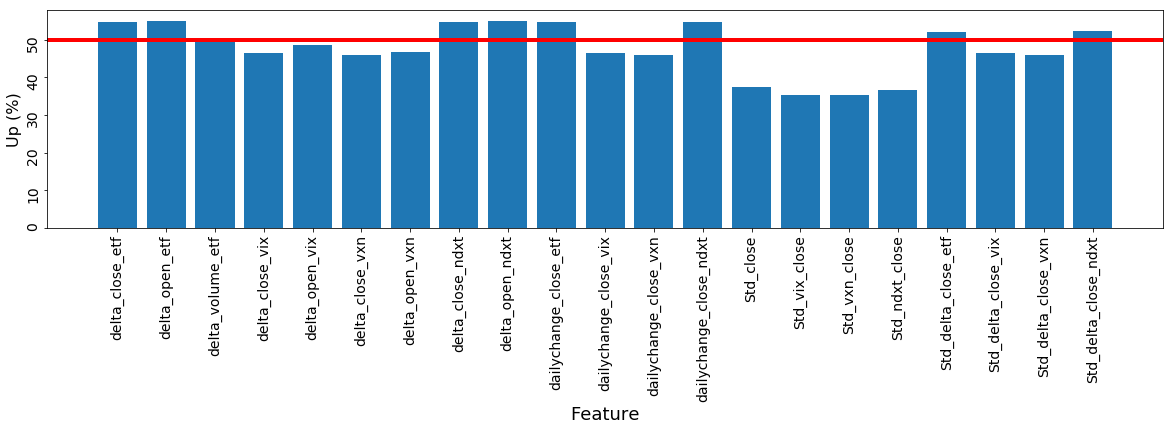

In [95]:
###### Identify variables/feature with higher chance of UP 

print frq.columns.values
pyplot.bar(np.arange(frq.shape[0]),frq['Up_Perc']) #,figsize = (8,2.5
pyplot.xticks(np.arange(frq.shape[0]), frq.index.values, fontsize=6,rotation=45)
pyplot.axhline(y=50,linewidth=4, color='r')
pyplot.rcParams["figure.figsize"] = [20,4]
pyplot.xlabel('Feature', fontsize=18)
pyplot.ylabel('Up (%)', fontsize=16)
pyplot.tick_params(labelsize = 14, labelrotation  = 90)
pyplot.show()

# * Distribution of Input and Target Variables *
***


HISTOGRAMS OF INDEXES

Variable to be Plotted DELTA_CLOSE_ETF


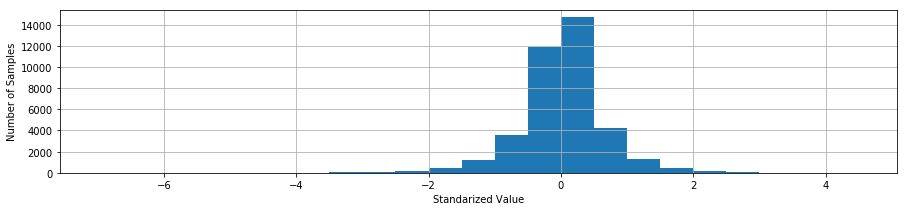

Variable to be Plotted DAILYCHANGE_CLOSE_ETF


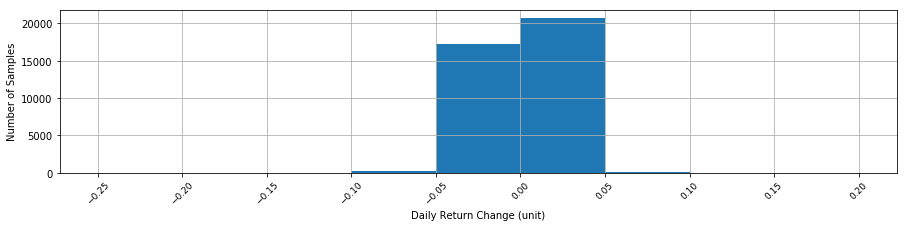

Variable to be Plotted STD_CLOSE


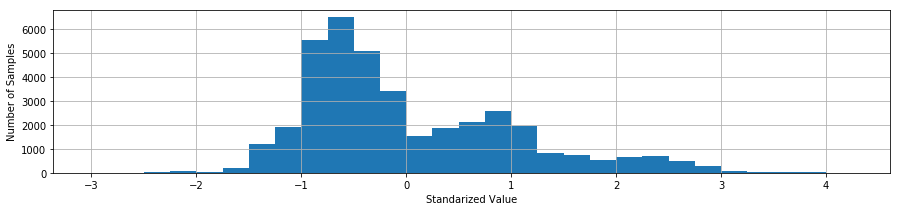

Variable to be Plotted DAILYCHANGE_CLOSE_VIX


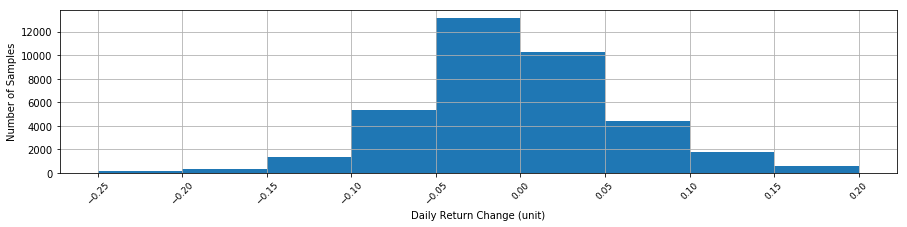

Variable to be Plotted STD_VIX_CLOSE


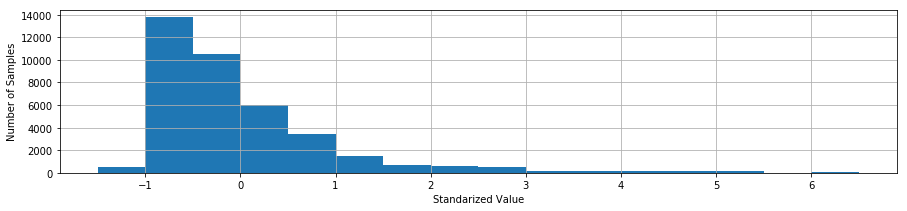

Variable to be Plotted DAILYCHANGE_CLOSE_VXN


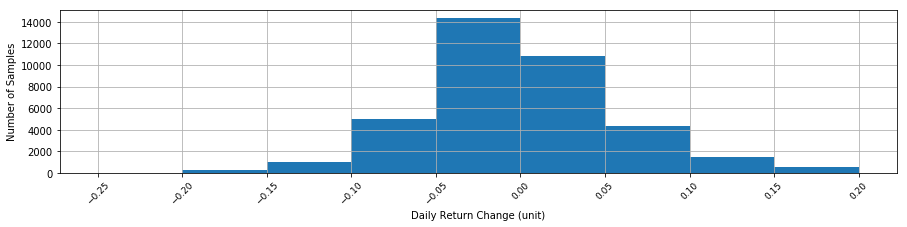

Variable to be Plotted STD_VXN_CLOSE


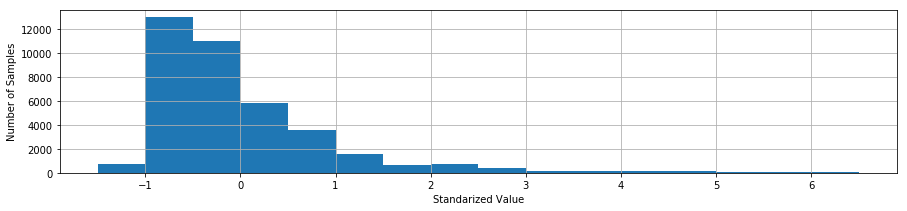

Variable to be Plotted DAILYCHANGE_CLOSE_NDXT


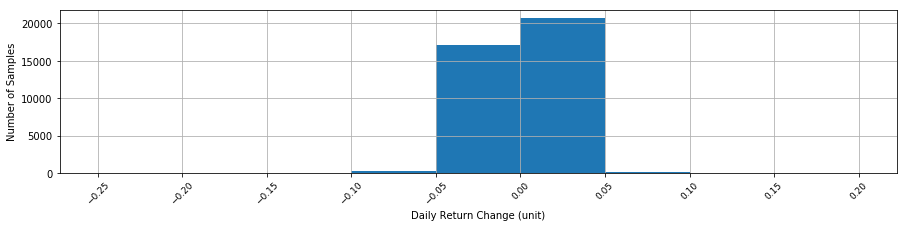

Variable to be Plotted STD_NDXT_CLOSE


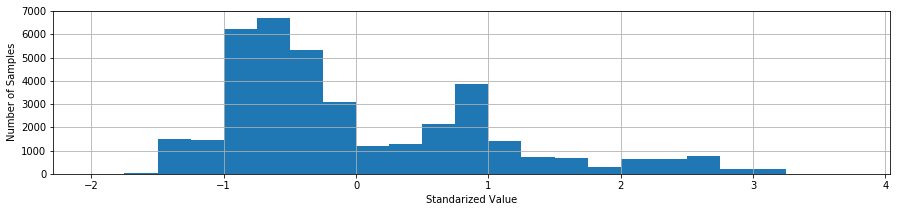

In [100]:
### EXPLORATORY VISUALIZATION

## Function to Round up values
def myround(x, prec=1, base=.5):
    return round(base * round(float(x)/base),prec)

NumCols = df_Final_Chosen_ETFs_Std.columns
print "HISTOGRAMS OF INDEXES"
print
tmp = [25,34,38,35,39,36,40,37,41]
for col in df_Final_Chosen_ETFs_Std.columns[tmp]: ## LOOKS INTO DATA COLUMNS OF THE SUBMATRIX
    print "Variable to be Plotted",col.upper()
    fig, ax = pyplot.subplots()    
    maxi = myround(df_Final_Chosen_ETFs_Std[col].max())
    mini = myround(df_Final_Chosen_ETFs_Std[col].min())
    if maxi- mini >= 7:
        bin = np.arange(mini-.5,maxi+.5,.5)
    else:
        bin = np.arange(mini-.5,maxi+.5,.25)
    
    if col.upper().find('DAILYCHANGE')>=0:
        ax.set_xlabel('Daily Return Change (unit)')
        pyplot.xticks(np.arange(-.25,.25,.05), fontsize=9,rotation=45)
        df_Final_Chosen_ETFs_Std[col].hist(bins = np.arange(-.25,.25,.05), figsize = (15,3))
    else:
        ax.set_xlabel('Standarized Value')
        df_Final_Chosen_ETFs_Std[col].hist(bins = bin, figsize = (15,3))

    ax.set_ylabel('Number of Samples')
    pyplot.show()

In [102]:
df_Final_Chosen_ETFs_Std.columns[[25]]

Index([u'delta_close_etf'], dtype='object')

In [ ]:
################################################################################
### IT WAS AN ATTEMPT TO SEE HOW WAS THE UP/DOWN DISTRIBUTION FOR EACH TICKER
### THE ISSUE IS THAT I CAN'T APPEND THE ROWS
################################################################################

ticlist = df_Final_Chosen_ETFs_Std.groupby('ticker')['ticker'].count()
ticlist = ticlist.index.values
print "Ticker list ",ticlist
tmp = df_Final_Chosen_ETFs_Std.columns[[25]] ## [42,43,45,46] HERE I DEFINE WHICH COLUMNS WILL BE ANALYZED, first column 42
print "Columns to Analyze ",tmp
for col in tmp: ## LOOKS INTO DATA COLUMNS OF THE SUBMATRIX
    frqgrp = pd.DataFrame(index = ['Down','No Change','Up','All','Up_Perc','Dw_Perc','NC_Perc'],columns = ['variable'])        
    if col == "Labeled_delta_close_etf":
        UpDownSummary = pd.DataFrame(columns= ['variable']+ ticlist[0:].tolist()) #
        print "Firsttime ", UpDownSummary.shape
    for tic in ticlist[0:]: ## LOOKS INTO DATA COLUMNS OF THE SUBMATRIX
        frqtab = pd.crosstab(index=df_Final_Chosen_ETFs_Std.loc[df_Final_Chosen_ETFs_Std['ticker']==tic,col],columns = tic,margins=True)
        print frqtab.head(5)
    frqgrp['variable'] = col
    print frqgrp.shape
    print "Current Column label ", col
    UpDownSummary = pd.concat([UpDownSummary,frqgrp],axis=0, ignore_index=False)
UpDownSummary

# *MODEL TRAINING AND TESTING PHASE*

***

In [155]:
################## DEFINE HELPER FUNCTIONS FOR EVALUATING MODELS AND PERFORMING CLASSIFICATIONS

def EvaluateROC(y_test,y_pred, plot = False):
        tprs = []
        std_auc=[]
        mean_fpr = np.linspace(0, 1, 100)
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        
        if plot:
            pyplot.rcParams["figure.figsize"] = [7,7]
            pyplot.plot(fpr, tpr, lw=1, alpha=0.3,label='ROC Score (AUC = %0.2f)' % (roc_auc))
            pyplot.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)
            pyplot.plot(mean_fpr, mean_tpr, color='b',label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=.8)
            pyplot.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
            pyplot.xlim([-0.05, 1.05])
            pyplot.ylim([-0.05, 1.05])
            pyplot.xlabel('False Positive Rate')
            pyplot.ylabel('True Positive Rate')
            pyplot.title('Receiver operating characteristic Direction Prediction')
            pyplot.legend(loc="lower right")
            pyplot.show()
            
        return mean_auc,roc_auc_score(y_test,y_pred)
    
def RunClassificationPredictions(X_train, y_train, X_test, y_test, classifier, Plot=False):
    classifier.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    y_pred = clf.predict(X_test)  
    # ROC Evaluation
    auc_mean , roc_auc_score_mean = EvaluateROC(y_test,y_pred,plot = Plot)
    return y_pred,score,auc_mean,roc_auc_score_mean

def RunGridSearchClassification(X_train, y_train, X_test, y_test, classifier,TSCV,param, Plot=False):
    gsearch = GridSearchCV(estimator=classifier, cv=TSCV,param_grid=param,n_jobs=-1)
    gsearch.fit(X_train, y_train)
    score = gsearch.score(X_test, y_test)
    y_pred = gsearch.predict(X_test)
    auc_mean , roc_auc_score_mean = EvaluateROC(y_test,y_pred,plot = Plot)
    return y_pred,score,auc_mean,roc_auc_score_mean,gsearch.best_params_



In [181]:
### INITIALIZE VARIABLES FOR TRAINING
numeric_columns = ['open','high','low','close','openint']
date_columns = [1,8,13,18]
closing_columns = ['date','ticker','close','Labeled_delta_close_etf',
                   'vix_close','Labeled_delta_close_vix',
                   'vxn_close','Labeled_delta_close_vxn',
                   'ndxt_close','Labeled_delta_close_ndxt',
                   'dailychange_close_etf','dailychange_close_vix',
                   'dailychange_close_vxn','dailychange_close_ndxt', u'Std_close']

####### TARGET FEATURES FOR TRAINING
X_Cols = ['ticker',  
          'delta_close_etf','dailychange_close_etf',
          'delta_close_vix','dailychange_close_vix',
          'delta_close_vxn','dailychange_close_vxn',
          'delta_close_ndxt','dailychange_close_ndxt']

####### LABEL FEATURE FOR TRAINING
Y_Cols = ['Labeled_delta_close_etf']


####### INITIATE VARIABLES FOR CLASSIFIERS AND GRIDSEARCHCV
randomstate = 1975
names = [
         "SVM", 
         "Decision Tree",
         "Random Forest",
         "Gaussian Naive Bayes",
         "Neural Net"]

classifiers = [
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),     
    GaussianNB(),
    MLPClassifier()]

parametersets = [
    {'kernel':('linear','rbf', 'sigmoid'),'random_state':[randomstate],'C':[0.0001,.025,1],'gamma':[0.0001,.025,1,10]}, 
    {'max_depth':[100,10, 5], 'max_features':('log2','sqrt'),'random_state':[randomstate]},
    {'n_estimators':[10],'random_state':[randomstate]},
    {None},
    {'activation':['relu','logistic'],'solver':( 'sgd', 'adam'), 'alpha':[0.0001, 1,10] }]


#############################################################
## Variable Targets -
## m -> Number of Days in the Future for forecasting
## n1 - > Moving Average for Market Index (days)
## n2 - > Moving Average gor Volatility (days)
#############################################################

m  = [1,5,10,20,90,270]   
n =[90,270,5,10,20]     # np.arange(1,560,5) 

#############################################################


### In case of using the data set from previous code
PreProcessed_data_ETF = df_Final_Chosen_ETFs_Std

###READ THE FILE(S) THIS MAY USED DURING DEVELOPMENT TIMES TO SAVE TIME RE-PROCESSING OF THE DATA EACH TIME
### In case of reading the file from previous stages, Open Pre-processed Files
filename = './Dataset/1Day/ETFs/PreProc_AllETFs_Chosen_WO_NoChange.csv'
### PreProcessed_data_ETF = pd.read_csv(filename, parse_dates=['date','date_x','date_y'],index_col='index')


In [183]:
#########################################################################################################
#### RUN PREDICTIONS AND HYPERPARAMETER OPTIMIZATION USING GRIDSEARCHCV AND TIME SERIES CROSS-VALIDATION
#########################################################################################################
########## CALCULATE VOLATILITY, MOMENTUM FOR ETF AND SECTOR INDEXES
########## EACH FEATURE CALCULATED AVERAGING OVER THE PAST N DAYS FOR 5,10,20,90,270

##  0. For each combination of ML Algorithm/Classifier, m, n1 and n2 execute the following:
##    1. Subset the original full dataset by Ticker/ETF 
##    2. Shift by "m" days to the past the target label
##    3. Because the last "m" rows now show as NA, these are removed from the dataset
##    4. Encode Label feature (targe predicted variable)
##    5. Calculate two features(volatility and momentum using Moving Average) to each variable given n1, n2 (N2 is parameter for ETF, and N1 for all other three indexes)
##       5.1 n1 and n2 may be 5,10,20,90,270. This will make NAs mane of the first rows of the data set
##       5.2 First "d" rows are removed from the dataset where d = (max(n1,n2)+1) th date
##    6. Subset dataset columns to only include explanatory features and target label feature
##    7. Transform the data: Apply Log10 (to daily returns) and Standardize all explanatory features 
##    8. Break dataset into TRAIN and TESTING sets with a 70% ratio for Training
##    9. Create Time Series Cross-Validator Object
##    10. Train Model using Cross-Validation and Hyper-Parameter optimization using GridSearchCV 
##       3.1 Random forest and Gausian Naive Bayes don't pass by GridSearchCV. The former because it needs to be out-of-the-cox and the latter because it does not have parametes to be passed to GridSearchCV
##    11. Predict on Testign given current m, n1 and n2 values
##    12. Evaluate accuracy using "accuracy score" and "AUC_ROC" score
##    13. Record on dataframe results from training/testing exercise: ['Ticker','INDEX_N','ETF_N','Forecast','Classifier','Accuracy Score','AUC Trap. Score','AUC_ROC Score', 'TrainingTesting Time', 'Optimized Hyper Parameters']


## Run simulation for one set of m,n1,n2
timestart  = time.time()
print "Local current time :", timestart
Train_Cols = ['mom_ETF','vol_ETF','mom_vix','vol_vix','mom_vxn','vol_vxn','mom_ndxt','vol_ndxt']
All_Scores = pd.DataFrame(columns = ['Ticker','INDEX_N','ETF_N','Forecast','Classifier','Accuracy Score','AUC Trapezoidal Score','AUC_ROC_Score','Simulation Duration in Secs','Final Estimator'])
# Defines # of folds for TS Cross-Validation
TS_splits = 3
# Defines if ROC charts will be plot or not
ShowPlots = False

filenameOut = './Dataset/1Day/ETFs/20180309 TrainingTestingResults.csv'
print 'Expected Number of Iterations = ', len(m)*len(n)*len(n)*5,'\n'
ind = 0
Cycletime2 = time.time()
for i in np.arange(5):#np.arange(5):# THIS IS A WORK AROUND FOR THE ML ALGORITHM TRAINNING CYCLE BELOW
    for n1 in n: #FOR INDEX
        All_Scores.to_csv(path_or_buf = filenameOut,index_label = "Iteration")
        for n2 in n: #FOR ETF
            for m1 in m:
                Cycletime = time.time()
                print 'Start Estimator for 13 Tickers = %s n1 = %d, n2 = %d, m = %d' % (names[i],n1,n2,m1),'Last Training took ',myround(Cycletime2, prec=2, base=.1),'seconds'
                for group, matrix in PreProcessed_data_ETF[X_Cols+Y_Cols].loc[PreProcessed_data_ETF['ticker']!='IxM'].groupby('ticker'): #.loc[PreProcessed_data_ETF['ticker']!='IoooM',
                    ind +=1
                    matrix = matrix.copy()
                    
                    ## Shift Target feature for Forecasting
                    matrix[Y_Cols] = matrix[Y_Cols].shift(-m1)
                    matrix  = matrix[:-m1] 

                    # Encode Target feature
                    le = LabelEncoder()
                    matrix[Y_Cols] = le.fit_transform(matrix[Y_Cols])

                    ### Create Features for Momentum and Volatility for each variable
                    matrix['mom_ETF'] = pd.rolling_mean(matrix['delta_close_etf'], n2)
                    matrix['vol_ETF'] = pd.rolling_mean(matrix['dailychange_close_etf'], n2)
                    matrix['mom_vix'] = pd.rolling_mean(matrix['delta_close_vix'], n1)
                    matrix['vol_vix'] = pd.rolling_mean(matrix['dailychange_close_vix'], n1)
                    matrix['mom_vxn'] = pd.rolling_mean(matrix['delta_close_vxn'], n1)
                    matrix['vol_vxn'] = pd.rolling_mean(matrix['dailychange_close_vxn'], n1)
                    matrix['mom_ndxt'] = pd.rolling_mean(matrix['delta_close_ndxt'], n1)
                    matrix['vol_ndxt'] = pd.rolling_mean(matrix['dailychange_close_ndxt'], n1)
                                        
                    ### Extract Explanatory Features and Target Features from raw dataset, remove NA rows after moving average features creation
                    FirstGoodSample = max(n1,n2)+1
                    matrix = matrix[Train_Cols+Y_Cols]
                    matrix = matrix[FirstGoodSample:]
                    X_All = matrix.loc[FirstGoodSample:,Train_Cols].values
                    Y_All = matrix.loc[FirstGoodSample:,Y_Cols].values
                    
                    ### Transform Explanatory Features: Apply Log10 to Daily Returns and Standardize all explanatory features
                    X_All[:,[1,3,5,7]] = np.log10(X_All[:,[1,3,5,7]]+1)
                    scaler = StandardScaler()
                    X_All = scaler.fit_transform(X_All)

                    ### SEPARATE TRAININIG AND TESTING SETS 70% training, 30% Testing
                    train = int(len(X_All)*.7)
                    X_train = X_All[:train]
                    y_train = Y_All[:train]
                    X_test = X_All[train:]
                    y_test = Y_All[train:]

                    #Create TS Cross-Validator
                    my_cv = TimeSeriesSplit(n_splits = TS_splits).split(X_train)
                    
                    # Training Process including Cross-Validation and Hyper-Parameter optimization using GridSearchCV
                    for name,clf,GS_Param in zip(names,classifiers,parametersets)[i:i+1]:
                        ## This FOR Loop is failing so a work around was created as the first FOR loop of the cycle above. It's been kept for others to see and with the hope to fix it on a later day
                        ## I have opened a forum question for it: https://discussions.udacity.com/t/iterating-multiple-estimators-with-gridsearchcv-valueerror-need-more-than-0-values-to-unpack/617716
                        ##http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py
                        
                        # Localtime1 will be used to time length of time for each training/testing iteration
                        localtime1 = time.time()
                        
                        # Run Classification and Testing procedure; it returns predicted Y values for testing set, and 
                        if name in ['Random Forest','Gaussian Naive Bayes']:
                            y_pred, score, auc_mean, roc_auc_score_mean = RunClassificationPredictions(X_train, y_train, X_test, y_test, clf, Plot = ShowPlots)
                            estim = clf.get_params()
                        else:
                            y_pred, score, auc_mean, roc_auc_score_mean,estim = RunGridSearchClassification(X_train, y_train, X_test, y_test, clf,my_cv,GS_Param, Plot = ShowPlots)
 
                        SimTime = time.time() - localtime1

                        # Record Results in Output Sumamry dataframe
                        All_Scores.loc[len(All_Scores)+1] = [group,n1,n2,m1,name,score,auc_mean,roc_auc_score_mean,SimTime,estim]   #['Ticker','INDEX_N','ETF_N','Forecast','Classifier','Accuracy Score','AUC Trap. Score','AUC_ROC Score', 'TrainingTesting Time', 'Optimized Hyper Parameters']]
                Cycletime2 = time.time() - Cycletime

timeend  = time.time()
print "Local current time :", timeend    
print "Total duration in Secs :", timeend  - timestart  




Local current time : 1520704347.95
Expected Number of Iterations =  750 

Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 90, m = 1 Last Training took  1520704348.0 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=90,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: pd.rolli

Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 90, m = 5 Last Training took  70.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 90, m = 10 Last Training took  69.8 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 90, m = 20 Last Training took  69.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 90, m = 90 Last Training took  69.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 90, m = 270 Last Training took  69.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 270, m = 1 Last Training took  66.6 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=270,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=270,center=False).mean()


Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 270, m = 5 Last Training took  66.7 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 270, m = 10 Last Training took  66.4 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 270, m = 20 Last Training took  66.4 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 270, m = 90 Last Training took  66.0 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 270, m = 270 Last Training took  66.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 5, m = 1 Last Training took  64.2 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()


Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 5, m = 5 Last Training took  69.8 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 5, m = 10 Last Training took  69.6 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 5, m = 20 Last Training took  69.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 5, m = 90 Last Training took  69.6 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 5, m = 270 Last Training took  68.8 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 10, m = 1 Last Training took  66.7 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()


Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 10, m = 5 Last Training took  69.0 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 10, m = 10 Last Training took  69.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 10, m = 20 Last Training took  69.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 10, m = 90 Last Training took  69.8 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 10, m = 270 Last Training took  67.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 20, m = 1 Last Training took  66.8 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()


Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 20, m = 5 Last Training took  68.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 20, m = 10 Last Training took  69.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 20, m = 20 Last Training took  70.4 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 20, m = 90 Last Training took  70.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 90, n2 = 20, m = 270 Last Training took  68.4 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 90, m = 1 Last Training took  65.8 seconds


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=270,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=270,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=270,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=270,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: pd.r

Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 90, m = 5 Last Training took  67.7 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 90, m = 10 Last Training took  66.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 90, m = 20 Last Training took  67.0 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 90, m = 90 Last Training took  67.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 90, m = 270 Last Training took  65.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 270, m = 1 Last Training took  64.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 270, m = 5 Last Training took  66.7 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 270, m = 10 Last Training took  67.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 270, m = 20 Last Training took  66.7 seconds
Start Estimator for 13 Tickers = SVM n1 = 270, n2 = 270, m = 90 Last Training took  66.8 seconds
Start Estimator for 13 Tickers = SVM 

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=5,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: pd.rolling_m

Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 90, m = 5 Last Training took  69.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 90, m = 10 Last Training took  69.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 90, m = 20 Last Training took  69.8 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 90, m = 90 Last Training took  69.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 90, m = 270 Last Training took  69.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 270, m = 1 Last Training took  66.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 270, m = 5 Last Training took  67.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 270, m = 10 Last Training took  67.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 270, m = 20 Last Training took  67.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 270, m = 90 Last Training took  67.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 5, n2 = 270, m 

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: pd.rolli

Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 90, m = 5 Last Training took  70.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 90, m = 10 Last Training took  69.6 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 90, m = 20 Last Training took  69.4 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 90, m = 90 Last Training took  71.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 90, m = 270 Last Training took  68.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 270, m = 1 Last Training took  66.7 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 270, m = 5 Last Training took  67.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 270, m = 10 Last Training took  67.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 270, m = 20 Last Training took  67.5 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n2 = 270, m = 90 Last Training took  67.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 10, n

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:79: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:82: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20,center=False).mean()
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:83: FutureWarning: pd.rolli

Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 90, m = 5 Last Training took  69.8 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 90, m = 10 Last Training took  69.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 90, m = 20 Last Training took  69.4 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 90, m = 90 Last Training took  69.9 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 90, m = 270 Last Training took  69.2 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 270, m = 1 Last Training took  66.0 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 270, m = 5 Last Training took  67.5 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 270, m = 10 Last Training took  67.1 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 270, m = 20 Last Training took  67.3 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n2 = 270, m = 90 Last Training took  67.6 seconds
Start Estimator for 13 Tickers = SVM n1 = 20, n

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:41: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 90, m = 5 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 90, m = 10 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 90, m = 20 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 90, m = 90 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 90, m = 270 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 270, m = 1 Last Training took  1.4 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 270, m = 5 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 270, m = 10 Last Training took  1.5 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 270, m = 20 Last Training took  1.4 seconds
Start Estimator for 13 Tickers = Random Forest n1 = 90, n2 = 2

# *FREE VISUALIZATION MODEL COMPARISON*

In [191]:
Forecast_df = All_Scores[All_Scores.Forecast == 90]
plotnine.options.figure_size = (15 ,8)


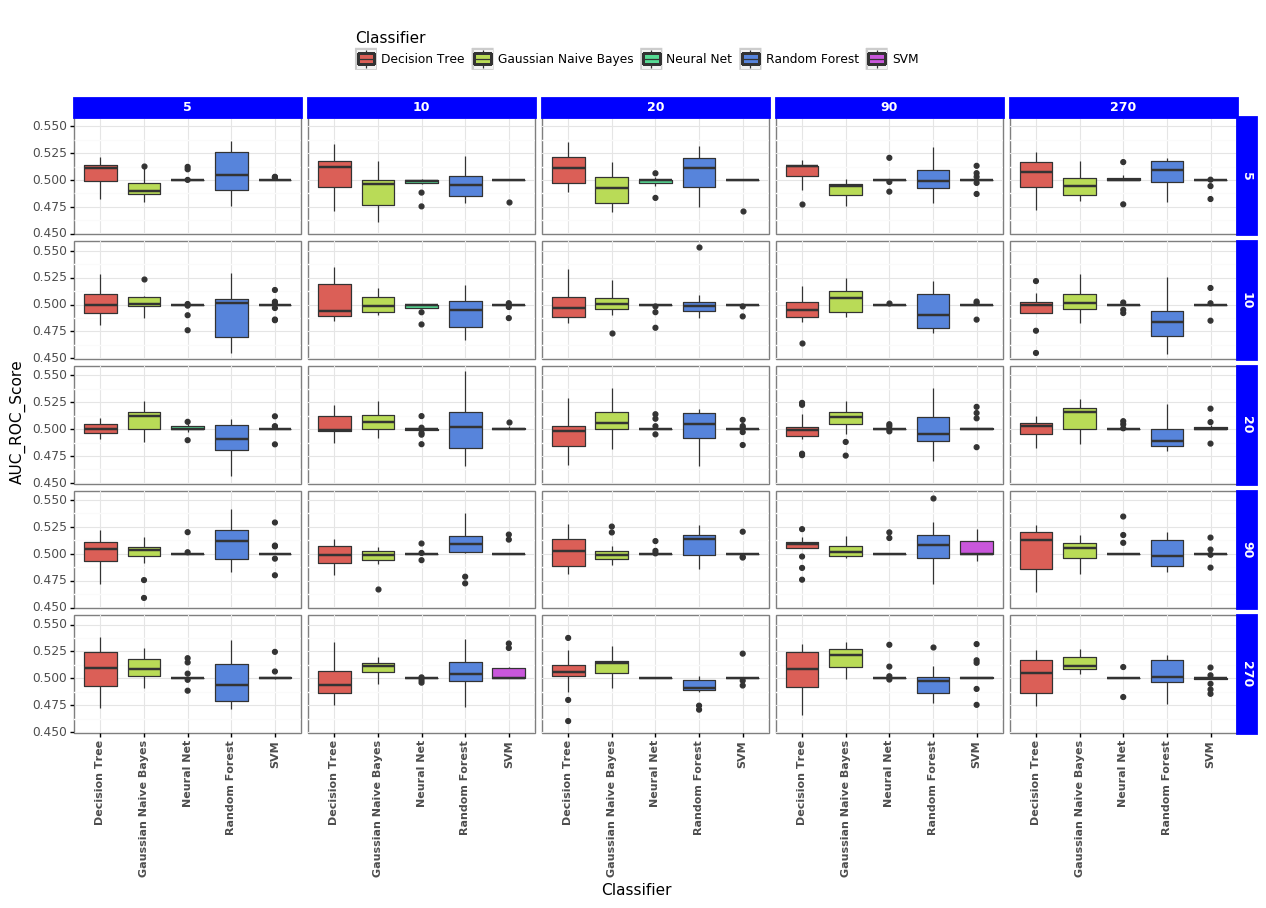

<ggplot: (16280173)>

In [192]:
ggplot(Forecast_df,aes(x = 'Classifier', y='AUC_ROC_Score', fill = 'Classifier')) + geom_boxplot() + facet_grid('INDEX_N~ETF_N') + theme_bw()+\
theme(strip_background=element_rect(color='blue', fill='blue', size=2),strip_text = element_text(size=9,color="white", face="bold")) +\
theme(legend_position = "top")  +\
theme(axis_text_x = element_text(size=8,face="bold",angle = 90, hjust = 0.5, vjust=1))